### **Self-supervised learning for denoising of multidimensional MRI data**

This repository provides a demonstration of our proposed MD-S2S (multidimensional Self2Self) algorithm.

To develop a fast denoising framework for high-dimensional data based on a self-supervised learning scheme, which does not require ground truth clean image.

In [1]:
import torch
import numpy as np
import scipy.io as sio
import time
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from data_augmentation import data_augmentation
from model_Resnet_relu import self2self

# GPU
GPU_NUM = 0 #GPU number
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available()
                      else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check   

/home/bgkang/.conda/envs/pytorch-bg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current cuda device  0


In [2]:
input_channel = 10
batch_size = 3
dir_data = "data/"

## Dataset #########################################################################
X_mat = sio.loadmat(dir_data + "input_invivo_diffusion_10bvalues.mat")
train_X = X_mat['input_invivo']
train_X = np.transpose(train_X,(0,3,1,2))

X_mat = sio.loadmat(dir_data + "input_invivo_test_diffusion_10bvalues.mat")
test_X = X_mat['input_invivo_test']
test_X = np.transpose(test_X,(0,3,1,2))

X_train=torch.FloatTensor(train_X)
X_test=torch.FloatTensor(test_X)
#####################################################################################
trainset = TensorDataset(X_train)
testset = TensorDataset(X_test)

trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=False)
#####################################################################################

print(X_train.size())
print(X_test.size())

torch.Size([45, 10, 128, 128])
torch.Size([5, 10, 128, 128])


In [3]:
mask_p=0.3
dropout_p=0.3
learning_rate =1e-5
epochs = 10000

## Model training
model = self2self(input_channel,input_channel,dropout_p)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
start_time_0epoch=time.time()
for itr in range(epochs):
    batch_loss=0
    for i,data in enumerate(trainloader):
        [X_batch]=data
        X_batch = X_batch.to(device)
        
        flip_v, flip_h = np.random.choice(2, size=2)
        Aug_input = data_augmentation(X_batch, flip_v, flip_h,device)
            
        p_mtx = np.random.uniform(size=[X_batch.shape[0],X_batch.shape[1],X_batch.shape[2],X_batch.shape[3]])
        mask = (p_mtx>mask_p).astype(np.double)
        mask = torch.tensor(mask).to(device, dtype=torch.float32)
        
        X_input = Aug_input
        y = Aug_input
        
        model.train()
        img_input_tensor = X_input*mask
        output = model(img_input_tensor)
         
        loss = torch.sum((output-y)*(output-y)*(1-mask))/torch.sum(1-mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
        
    if (itr+1)%1000 == 0:
        print("iteration %d, loss = %.6f" % (itr+1, loss.item()))
        print('Time taken =', '{:.3f}'.format(time.time()-start_time_0epoch))  

iteration 1000, loss = 243.492371
Time taken = 620.814
iteration 2000, loss = 150.130493
Time taken = 1238.655
iteration 3000, loss = 98.030228
Time taken = 1859.434
iteration 4000, loss = 117.019104
Time taken = 2476.751
iteration 5000, loss = 95.277054
Time taken = 3094.806
iteration 6000, loss = 105.089821
Time taken = 3714.531
iteration 7000, loss = 142.868683
Time taken = 4330.689
iteration 8000, loss = 78.576454
Time taken = 4948.029
iteration 9000, loss = 80.500793
Time taken = 5564.484
iteration 10000, loss = 148.061447
Time taken = 6180.582


In [5]:
NPred=100
sum_preds = np.zeros(X_test.size())

start_time_test=time.time()
for i,data in enumerate(testloader):
    [X_batch]=data
    X_batch = X_batch.to(device)
    idxs=list(range(i,(i+1)))
    
    for j in range(NPred):
        p_mtx = np.random.uniform(size=X_batch.shape)
        mask = (p_mtx>mask_p).astype(np.double)
        mask = torch.tensor(mask).to(device, dtype=torch.float32)
        
        img_input = X_batch*mask
        
        output_test = model(img_input)
        sum_preds[idxs,:,:,:] += output_test.squeeze().detach().cpu().numpy()
    
sum_preds=sum_preds/NPred

print('Inference Time =', '{:.3f}'.format(time.time()-start_time_test))  

Inference Time = 3.995


Text(0.5, 1.0, 'Denoised Img')

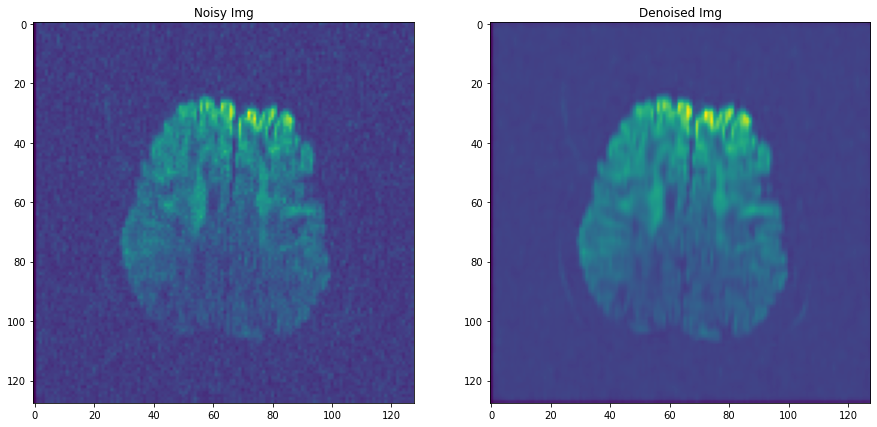

In [6]:
slice = 3
bvalue_num = 9

img1 = test_X[slice,bvalue_num,:,:]
img2 = sum_preds[slice,bvalue_num,:,:]

fig, ax = plt.subplots(1, 2,figsize=(15, 15))

ax[0].imshow(img1)
ax[0].set_title('Noisy Img')

ax[1].imshow(img2)
ax[1].set_title('Denoised Img')